# Tier 2. Module 2: Machine Learning. Fundamentals and Applications
## Topics 1-4 - Algorithms of learning with a teacher Part 1
## Homework

During the consideration of the topic, some stages of data preparation were deliberately omitted, which could affect the quality of training of the basic model. As a homework assignment, try to implement these missing steps and evaluate the performance of the new model.

### 1. Import of the required packages

In [18]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

### 2. Download the California Housing dataset

In [2]:
california_housing = fetch_california_housing(as_frame=True)

data = california_housing['frame']
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Defining the target variable

In [3]:
target = data.pop('MedHouseVal')
target.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

Checking data types and missing values

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


Features distribution

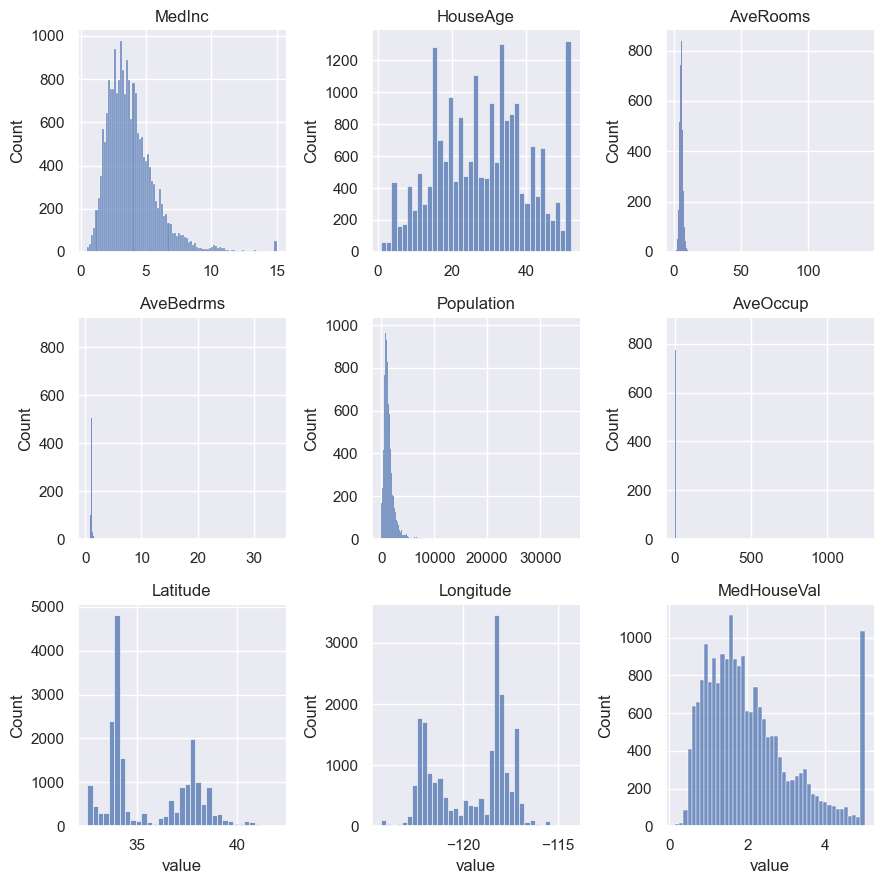

In [6]:
sns.set_theme()

melted = pd.concat([data, target], axis=1).melt()

g = sns.FacetGrid(melted,
                  col='variable',
                  col_wrap=3,
                  sharex=False,
                  sharey=False)

# The 'warnings' package hides all possible warnings during the code execution
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    g.map(sns.histplot, 'value')

g.set_titles(col_template='{col_name}')

g.tight_layout()

### 3. Additional data preprocessing

#### 3.1. Outlier cleaning for `AveRooms`, `AveBedrms`, `AveOccup` and `Population` columns

In [7]:
features_of_interest = ['AveRooms', 'AveBedrms', 'AveOccup', 'Population']
data[features_of_interest].describe()

,AveRooms,AveBedrms,AveOccup,Population
count,20640.000000,20640.000000,20640.000000,20640.000000
mean,5.429000,1.096675,3.070655,1425.476744
std,2.474173,0.473911,10.386050,1132.462122
min,0.846154,0.333333,0.692308,3.000000
25%,4.440716,1.006079,2.429741,787.000000
50%,5.229129,1.048780,2.818116,1166.000000
75%,6.052381,1.099526,3.282261,1725.000000
max,141.909091,34.066667,1243.333333,35682.000000


An outlier is identified by the 'three sigma' rule — to consider as outliers values of characteristics that deviate from the average by more than three standard deviations.

In [8]:
z_scores = data[features_of_interest].apply(zscore)
outlier_mask = (z_scores.abs() > 3).any(axis=1)

clean_data = data[~outlier_mask]
clean_target = target[~outlier_mask]
clean_data.shape

(20135, 8)

Selection of features for modeling

Text(0.5, 1.0, 'Median house value depending of\n their spatial location')

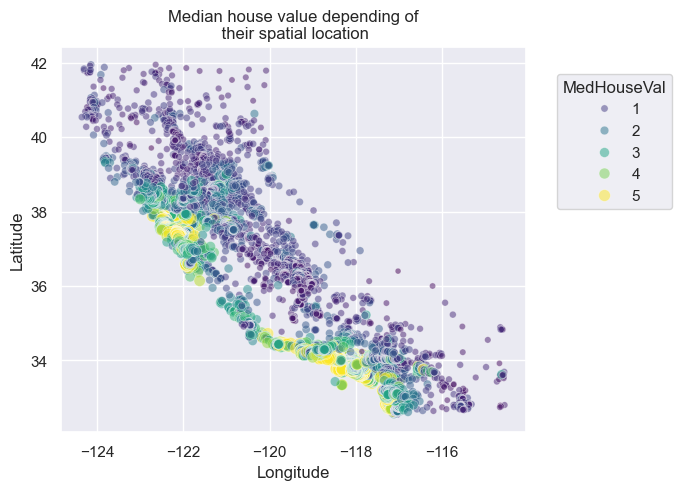

In [9]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.scatterplot(
    data=clean_data,
    x='Longitude',
    y='Latitude',
    size=clean_target,
    hue=clean_target,
    palette='viridis',
    alpha=0.5,
    ax=ax)

plt.legend(
    title='MedHouseVal',
    bbox_to_anchor=(1.05, 0.95),
    loc='upper left')

plt.title('Median house value depending of\n their spatial location')

#### 3.2 Removal from a set of features with high correlation between themselves

Correlation matrix

<Axes: >

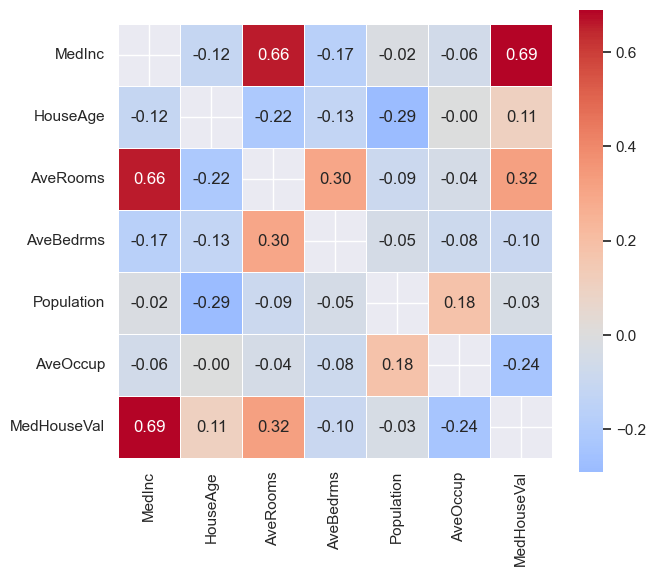

In [10]:
columns_drop = ['Longitude', 'Latitude']
subset = pd.concat([clean_data, clean_target],
                   axis=1).drop(columns=columns_drop)

corr_mtx = subset.corr()

mask_mtx = np.zeros_like(corr_mtx)
np.fill_diagonal(mask_mtx, 1)

fig, ax = plt.subplots(figsize=(7, 6))

# The mask is used in the correlation heatmap to hide the diagonal
sns.heatmap(subset.corr(),
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.2f',
            linewidth=0.5,
            square=True,
            mask=mask_mtx,
            ax=ax)

AveRooms and MedInc have 66% correlation between them. AveRooms to be deleted because it has lower correlation with the target MedHouseVal.

In [11]:
clean_data = clean_data.drop(columns=["AveRooms"])
clean_data.shape

(20135, 7)

### 4. Breakdown of the data set into training and test samples

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    clean_data,
    clean_target,
    test_size=0.2,
    random_state=42)

### 5. Normalization of features

In [13]:
scaler = StandardScaler().set_output(transform='pandas').fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.describe()

,MedInc,HouseAge,AveBedrms,Population,AveOccup,Latitude,Longitude
count,1.610800e+04,1.610800e+04,1.610800e+04,1.610800e+04,1.610800e+04,1.610800e+04,1.610800e+04
mean,-1.676224e-17,-1.248346e-16,1.764447e-17,-1.060874e-16,-3.793561e-17,-1.722100e-15,-8.151744e-16
std,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00
min,-1.773858e+00,-2.240869e+00,-5.444216e+00,-1.644220e+00,-2.448193e+00,-1.450260e+00,-2.367900e+00
25%,-6.876112e-01,-7.974045e-01,-4.671025e-01,-6.811515e-01,-5.624555e-01,-7.992891e-01,-1.106958e+00
50%,-1.764550e-01,4.520411e-03,-1.525954e-01,-2.266418e-01,-1.286644e-01,-6.447421e-01,5.377489e-01
75%,4.568290e-01,6.460603e-01,2.172224e-01,4.354681e-01,3.899295e-01,9.709764e-01,7.869470e-01
max,5.862520e+00,1.848948e+00,1.070880e+01,4.271775e+00,3.487352e+01,2.951988e+00,2.511397e+00


### 6. Model construction

In [14]:
model = LinearRegression().fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

ymin, ymax = y_train.agg(['min', 'max']).values

# Clip method is used to ensure that there are no unreal prices as 0 or infinity
y_pred = pd.Series(y_pred, index=X_test_scaled.index).clip(ymin, ymax)
y_pred.head()

7969     2.415358
17082    2.745517
5623     1.710072
16934    2.593909
7501     1.638296
dtype: float64

### 7. Assessment of model accuracy

In [15]:
r_sq = model.score(X_train_scaled, y_train)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'R2: {r_sq:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f}')

R2: 0.64 | MAE: 0.50 | MAPE: 0.29


Model coefficients

In [16]:
pd.Series(model.coef_, index=X_train_scaled.columns)

MedInc        0.716183
HouseAge      0.135899
AveBedrms     0.091373
Population    0.043995
AveOccup     -0.232099
Latitude     -1.022909
Longitude    -0.949422
dtype: float64

In [17]:
pd.Series(model.intercept_, name="Intercept")

0    2.070843
Name: Intercept, dtype: float64

### 8. Conclusions

The accuracy of the model has been increased by about 2% compared to the model given in the outline. Thus, MAE decreased from 52 to 50%, and MAPE from 31 to 29%. R2 increased from 0.61 to 0.64.